# VibeCheck AI: Emotion Detection from Speech

---  

##  Objective
We aim to build a deep learning system that classifies speech audio into **five emotions** — `happy`, `sad`, `angry`, `neutral`, and `excited` (if available in dataset) using the RAVDESS dataset. This notebook will cover audio preprocessing, feature extraction, data augmentation, model training (CNN, RNN, hybrid), and evaluation.


## -- 1. Setup & Imports --
* Install necessary libraries if required with `!pip xyz -q`

In [31]:
# Import modules
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from audiomentations import Compose, TimeStretch, PitchShift, Shift
import warnings
from pathlib import Path
import shutil
from tqdm import tqdm
import optuna
warnings.filterwarnings("ignore")

## -- 2. Data Preparation (RAVDESS Subset Extractor) --
* Assumes RAVDESS audio data is extracted locally.

In [5]:
emotion_map = {
    "01": "neutral",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "08": "excited"  # excited mapped from 'surprised' if present
}

In [12]:
ravdess_root = "data/Audio_Speech_Actors_01-24"
output_dir = "data/filtered_ravdess"
os.makedirs(output_dir, exist_ok=True)

for actor_dir in Path(ravdess_root).rglob("*.wav"):
    parts = actor_dir.name.split("-")
    emotion_id = parts[2]
    if emotion_id in emotion_map:
        label = emotion_map[emotion_id]
        dest_dir = os.path.join(output_dir, label)
        os.makedirs(dest_dir, exist_ok=True)
        shutil.copy(actor_dir, os.path.join(dest_dir, actor_dir.name))


---

## -- 3. Audio Feature Extraction --
* #### Extract MFCCs, Mel Spectrogram, Chroma, ZCR. Apply fixed-length padding/truncation.


In [13]:
SAMPLE_RATE = 16000
DURATION = 3  # 3 seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION


def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=SAMPLE_RATE, mono=True)
    y = librosa.util.fix_length(data=y, size=SAMPLES_PER_TRACK)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=40)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)
    features = np.vstack([mfcc, mel, chroma, zcr])
    return features

---

## 4. Dataset Construction
# Load, label encode, normalize, and structure audio features.

In [14]:
def get_data_from_dir(root_dir):
    data, labels = [], []
    for label in os.listdir(root_dir):
        for file in os.listdir(os.path.join(root_dir, label)):
            fpath = os.path.join(root_dir, label, file)
            features = extract_features(fpath)
            data.append(features)
            labels.append(label)
    return np.array(data), np.array(labels)

X, y = get_data_from_dir(output_dir)
X = X.transpose(0, 2, 1)  # (samples, time, features)
le = LabelEncoder()
y_encoded = le.fit_transform(y)
scaler = StandardScaler()
X = np.array([scaler.fit_transform(x) for x in X])

---

## 5. Data Augmentation
# TimeStretch, PitchShift, and Shift are applied randomly to improve model robustness.

In [15]:
from audiomentations import Compose, TimeStretch, PitchShift, Shift

augment = Compose([
    TimeStretch(min_rate=0.9, max_rate=1.1, p=0.5),
    PitchShift(min_semitones=-2, max_semitones=2, p=0.5),
    Shift(min_shift=-0.2, max_shift=0.2, p=0.5)
])
# Applied only during training (in DataLoader or collate_fn)

---

## 6. PyTorch Dataset

In [16]:
class EmotionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


---

## 7. Model Architectures


In [39]:
# CNN Classifier
#Designed to extract spatial features from spectrograms.
class CNNEmotion(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.1):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), padding=1)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(32 * 47 * 46, 128) # This will be corrected in forward
        self.dropout = nn.Dropout(dropout_rate)
        self.out = nn.Linear(128, num_classes)
        self._to_linear = None # Placeholder for the calculated flattened size

    def forward(self, x):
        # Check if the input is 3D (no channel dimension)
        if len(x.shape) == 3:
            x = x.unsqueeze(1)  # Add the channel dimension

        # Now x should be 4D: [B, C, T, F]
        x = F.relu(self.conv1(x))
        x = self.pool(x)

        # Dynamically calculate the size of the flattened output
        if self._to_linear is None:
            self._to_linear = x.view(x.size(0), -1).shape[1]

        x = x.view(x.size(0), -1) # Flatten for the fully connected layer
        x = F.relu(self.fc1(x))
        x = self.out(x)
        return x
    
# CNN Classifier
# class CNNEmotion(nn.Module):
#     def __init__(self, num_classes, dropout_rate=0.3):
#         super().__init__()
#         self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), padding=1)
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1)
#         self.pool = nn.MaxPool2d(2)
#         self.dropout = nn.Dropout(dropout_rate)
#         self.batch_norm1 = nn.BatchNorm2d(32)
#         self.batch_norm2 = nn.BatchNorm2d(64)
#         self._to_linear = None
#         # The actual size will be calculated in forward pass
#         self.fc1 = nn.Linear(1, 128)  # Placeholder, will be updated in forward pass
#         self.out = nn.Linear(128, num_classes)

#     def forward(self, x):
#         # Check if the input is 3D (no channel dimension)
#         if len(x.shape) == 3:
#             x = x.unsqueeze(1)  # Add the channel dimension
        
#         # Now x should be 4D: [B, C, T, F]
#         x = self.pool(F.relu(self.batch_norm1(self.conv1(x))))
#         x = self.pool(F.relu(self.batch_norm2(self.conv2(x))))
        
#         # Dynamically calculate the size of the flattened output on first run
#         if self._to_linear is None:
#             self._to_linear = x.view(x.size(0), -1).shape[1]
#             # Update fc1 input size
#             self.fc1 = nn.Linear(self._to_linear, 128).to(x.device)
        
#         x = x.view(x.size(0), -1)  # Flatten
#         x = self.dropout(F.relu(self.fc1(x)))
#         x = self.out(x)
#         return x

In [25]:
### LSTM Model
# Ideal for learning temporal patterns in MFCC sequences.
# class LSTMEmotion(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, num_classes):
#         super().__init__()
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
#         self.fc = nn.Linear(hidden_size, num_classes)

#     def forward(self, x):
#         out, _ = self.lstm(x)
#         return self.fc(out[:, -1, :])

class LSTMEmotion(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate=0.3):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size, 
            hidden_size, 
            num_layers, 
            batch_first=True, 
            dropout=dropout_rate if num_layers > 1 else 0,
            bidirectional=True
        )
        # Multiply by 2 for bidirectional
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        # Make sure input is 3D: [batch, seq, features]
        if len(x.shape) == 4:  # If input is spectrogram [B, C, T, F]
            batch_size, channels, time_steps, features = x.shape
            x = x.view(batch_size, time_steps, channels * features)
        
        out, _ = self.lstm(x)
        # Take the output from the last time step
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

In [43]:
# Model 3: Transformer-based model
class TransformerEmotion(nn.Module):
    def __init__(self, input_size, num_classes, d_model=128, nhead=8, num_encoder_layers=4, 
                 dim_feedforward=512, dropout=0.3):
        super().__init__()
        
        self.input_size = input_size
        self.d_model = d_model
        
        # Project input features to d_model dimensions
        self.input_projection = nn.Linear(input_size, d_model)
        
        # Positional encoding - learnable
        self.pos_encoder = nn.Parameter(torch.zeros(1000, d_model))  # Max sequence length: 1000
        
        # Transformer encoder
        encoder_layers = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_encoder_layers)
        
        # Output layer
        self.classifier = nn.Sequential(
            nn.Linear(d_model, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        # Handle input dimensionality
        if len(x.shape) == 4:  # If input is spectrogram [B, C, T, F]
            batch_size, channels, time_steps, features = x.shape
            x = x.view(batch_size, time_steps, channels * features)
        
        # Project input to d_model dimensions
        x = self.input_projection(x)  
        
        # Add positional encoding (take only what we need)
        seq_len = x.size(1)
        x = x + self.pos_encoder[:seq_len, :].unsqueeze(0)
        
        # Apply transformer encoder
        x = self.transformer_encoder(x)
        
        # Global average pooling over sequence length dimension
        x = torch.mean(x, dim=1)
        
        # Classification
        output = self.classifier(x)
        
        return output

In [54]:
class ResidualBlock(nn.Module):
    """
    A single residual block for the ResNet.
    Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
        stride (int): Stride for the first convolution layer. Default is 1.
        dropout_rate (float): Dropout rate for the Dropout2d layer within the block.
    """
    def __init__(self, in_channels, out_channels, stride=1, dropout_rate=0.1):
        super().__init__()
        
        # First convolutional layer in the block
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True) # ReLU activation
        # Dropout2d is used for feature maps (spatial dropout)
        self.dropout_conv = nn.Dropout2d(p=dropout_rate) 

        # Second convolutional layer in the block
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Downsample layer for the shortcut connection if dimensions or channels change
        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x # Store the input for the shortcut connection

        # Main path
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout_conv(out) # Apply dropout after the first activation

        out = self.conv2(out)
        out = self.bn2(out)

        # Shortcut connection
        if self.downsample is not None:
            identity = self.downsample(x)
        
        out += identity # Add the shortcut connection
        out = self.relu(out) # Final activation for the block
        
        return out

class ResNetEmotion(nn.Module):
    """
    Residual CNN model for emotion recognition.
    Args:
        num_classes (int): Number of output classes.
        dropout_rate (float): Dropout rate for FC layers and conv blocks. Default is 0.1.
    """
    def __init__(self, num_classes, dropout_rate=0.1):
        super().__init__()
        
        self.num_classes = num_classes
        self.dropout_rate = dropout_rate
        self.base_channels = 32 # Base number of channels for the first conv layers

        # Initial convolution layer
        # Input shape: [Batch, Channels, Time, Frequency], e.g., [B, 1, T, F]
        self.conv1 = nn.Conv2d(1, self.base_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.base_channels)
        self.relu = nn.ReLU(inplace=True) # Re-usable ReLU activation
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # Halves Time and Frequency dimensions

        # Residual blocks
        # Block 1: Maintains dimensions and channel count (base_channels -> base_channels)
        self.res_block1 = ResidualBlock(self.base_channels, self.base_channels, stride=1, dropout_rate=self.dropout_rate)
        
        # Block 2: Doubles channels and halves dimensions (base_channels -> base_channels * 2)
        self.res_block2 = ResidualBlock(self.base_channels, self.base_channels * 2, stride=2, dropout_rate=self.dropout_rate)
        self.current_channels = self.base_channels * 2 # Update current channel count

        # (Optional) Add more blocks for a deeper network if needed:
        # self.res_block3 = ResidualBlock(self.current_channels, self.current_channels, stride=1, dropout_rate=self.dropout_rate)
        # self.res_block4 = ResidualBlock(self.current_channels, self.current_channels * 2, stride=2, dropout_rate=self.dropout_rate)
        # self.current_channels *= 2

        # Global average pooling reduces each feature map to a single value
        self.adaptive_avg_pool = nn.AdaptiveAvgPool2d((1, 1)) # Output: [B, current_channels, 1, 1]

        # Fully connected layers for classification
        self.fc1 = nn.Linear(self.current_channels, 128) # FC layer, e.g., 64 -> 128
        self.dropout_fc = nn.Dropout(p=self.dropout_rate) # Dropout for the FC layer
        self.out = nn.Linear(128, self.num_classes) # Output layer

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        """Initializes weights for Conv2d and BatchNorm2d layers."""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        """
        Forward pass of the ResNetEmotion model.
        Args:
            x (torch.Tensor): Input tensor. Expected shape [B, T, F] or [B, 1, T, F].
        Returns:
            torch.Tensor: Output tensor with shape [B, num_classes].
        """
        # Ensure input is 4D: [Batch, Channels, Time, Frequency]
        if len(x.shape) == 3:  # If input is [B, T, F]
            x = x.unsqueeze(1)  # Add channel dimension: [B, 1, T, F]
        elif len(x.shape) != 4 or x.shape[1] != 1:
             # This model assumes a single input channel (e.g., grayscale spectrogram)
             # If multi-channel input, self.conv1's in_channels needs to change.
            pass # Allow for [B, C, T, F] if C is already 1. Or raise error if C > 1 and not handled.
            # For now, we assume if 4D, it's [B, 1, T, F] or user adapts conv1

        # Initial convolution part
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool1(x) # Shape: [B, base_channels, T/2, F/2]

        # Residual blocks
        x = self.res_block1(x) # Shape: [B, base_channels, T/2, F/2]
        x = self.res_block2(x) # Shape: [B, base_channels*2, T/4, F/4]
        # If more blocks were added:
        # x = self.res_block3(x)
        # x = self.res_block4(x)

        # Pooling and Classification
        x = self.adaptive_avg_pool(x) # Shape: [B, current_channels, 1, 1]
        x = x.view(x.size(0), -1)    # Flatten: [B, current_channels]
        
        x = self.fc1(x)
        x = self.relu(x) # Activation after the first FC layer
        x = self.dropout_fc(x) # Apply dropout
        x = self.out(x) # Final output
        
        return x

---

## 8. Training & Hyperparameter Tuning

# Reasoning: Adam optimizer + moderate LR + stratified sampling + early stopping

In [32]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, stratify=y_train_val)
train_val_ds = EmotionDataset(X_train_val, y_train_val)
train_ds = EmotionDataset(X_train, y_train)
val_ds = EmotionDataset(X_val, y_val)
test_ds = EmotionDataset(X_test, y_test)
train_val_loader = DataLoader(train_val_ds, batch_size=16, shuffle=True)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16)
test_loader = DataLoader(test_ds, batch_size=16)

In [ ]:
#model = CNNEmotion(num_classes=len(le.classes_))
model = TransformerEmotion()


In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8)

In [ ]:
# from tqdm import tqdm  # Import tqdm for progress bars

# # Training loop with tqdm progress bar
# for epoch in range(40):
#     model.train()
#     epoch_loss = 0
#     progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{40}", leave=False)
    
#     for Xb, yb in progress_bar:
#         Xb, yb = Xb.to(device), yb.to(device)
#         optimizer.zero_grad()
#         loss = criterion(model(Xb), yb)
#         loss.backward()
#         optimizer.step()
        
#         epoch_loss += loss.item()
#         progress_bar.set_postfix(loss=loss.item())
    
#     scheduler.step()
#     if (epoch + 1) % 4 == 0:
#         print(f"Epoch {epoch+1} completed. Average Loss: {epoch_loss/len(train_loader):.4f}")

Epoch 4 completed. Average Loss: 0.3061


Epoch 8 completed. Average Loss: 0.0214


Epoch 12 completed. Average Loss: 0.0098


Epoch 16 completed. Average Loss: 0.0058


Epoch 20 completed. Average Loss: 0.0041


Epoch 24 completed. Average Loss: 0.0033


Epoch 28 completed. Average Loss: 0.0027


Epoch 32 completed. Average Loss: 0.0022


Epoch 36 completed. Average Loss: 0.0019


Epoch 40 completed. Average Loss: 0.0017


In [33]:
# Function to train a model
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, 
                num_epochs=40, patience=8, model_path='best_model.pt'):
    """
    Train the model with early stopping
    """
    best_val_loss = float('inf')
    best_val_acc = 0.0
    early_stop_counter = 0
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            progress_bar.set_postfix(loss=loss.item(), accuracy=correct/total)
        
        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_loss = val_loss / len(val_loader)
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        # Print progress
        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        # Learning rate scheduler
        if scheduler:
            scheduler.step()
        
        # Save the best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_val_loss = val_loss
            early_stop_counter = 0
            torch.save(model.state_dict(), model_path)
            print(f"Saved best model with Val Acc: {val_acc:.4f}")
        else:
            early_stop_counter += 1
            
        # Early stopping
        if early_stop_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break
    
    # Load the best model
    model.load_state_dict(torch.load(model_path))
    
    return model, {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs,
        'best_val_acc': best_val_acc
    }

In [36]:
# Function for hyperparameter tuning with Optuna
def objective_cnn(trial):
    """
    Objective function for Optuna to optimize CNN hyperparameters
    """
    # Hyperparameters to optimize
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    gamma = trial.suggest_float('gamma', 0.5, 0.95)
    step_size = trial.suggest_int('step_size', 3, 10)
    
    # Create data loaders with the suggested batch_size
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size)
    
    # Initialize the model
    model = CNNEmotion(num_classes=len(emotion_map), dropout_rate=dropout_rate).to(device)
    
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    
    # Train for a few epochs to see how it performs
    trial_epochs = 15  # Reduced number of epochs for faster trials
    patience = 5
    
    best_val_acc = 0.0
    
    for epoch in range(trial_epochs):
        # Training
        model.train()
        running_loss = 0.0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_acc = val_correct / val_total
        
        # Update best accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            early_stop_counter = 0
        else:
            early_stop_counter += 1
        
        # Step the scheduler
        scheduler.step()
        
        # Report intermediate result
        trial.report(val_acc, epoch)
        
        # Early stopping
        if early_stop_counter >= patience:
            break
        
        # Handle pruning
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    
    return best_val_acc

In [ ]:
# Function for hyperparameter tuning with Optuna
def objective_rcnn(trial):
    """
    Objective function for Optuna to optimize CNN hyperparameters
    """
    # Hyperparameters to optimize
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    gamma = trial.suggest_float('gamma', 0.5, 0.95)
    step_size = trial.suggest_int('step_size', 3, 10)
    
    # Create data loaders with the suggested batch_size
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size)
    
    # Initialize the model
    model = ResNetEmotion(num_classes=len(emotion_map), dropout_rate=dropout_rate).to(device)
    
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    
    # Train for a few epochs to see how it performs
    trial_epochs = 15  # Reduced number of epochs for faster trials
    patience = 5
    
    best_val_acc = 0.0
    
    for epoch in range(trial_epochs):
        # Training
        model.train()
        running_loss = 0.0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_acc = val_correct / val_total
        
        # Update best accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            early_stop_counter = 0
        else:
            early_stop_counter += 1
        
        # Step the scheduler
        scheduler.step()
        
        # Report intermediate result
        trial.report(val_acc, epoch)
        
        # Early stopping
        if early_stop_counter >= patience:
            break
        
        # Handle pruning
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    
    return best_val_acc

In [37]:
def objective_lstm(trial):
    """
    Objective function for Optuna to optimize LSTM hyperparameters
    """
    # Hyperparameters to optimize
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    hidden_size = trial.suggest_categorical('hidden_size', [64, 128, 256])
    num_layers = trial.suggest_int('num_layers', 1, 3)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    gamma = trial.suggest_float('gamma', 0.5, 0.95)
    step_size = trial.suggest_int('step_size', 3, 10)
    
    # Create data loaders with the suggested batch_size
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size)
    
    # Determine input size based on data shape
    sample_data = next(iter(train_loader))[0]
    if len(sample_data.shape) == 4:  # If working with spectrograms
        input_size = sample_data.shape[1] * sample_data.shape[3]  # Channels * Features
    else:  # If working with MFCCs or similar
        input_size = sample_data.shape[2]  # Feature dimension
    
    # Initialize the model
    model = LSTMEmotion(
        input_size=input_size,
        hidden_size=hidden_size,
        num_layers=num_layers,
        num_classes=len(emotion_map),
        dropout_rate=dropout_rate
    ).to(device)
    
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    
    # Train for a few epochs to see how it performs
    trial_epochs = 15  # Reduced number of epochs for faster trials
    patience = 5
    
    best_val_acc = 0.0
    early_stop_counter = 0
    
    for epoch in range(trial_epochs):
        # Training
        model.train()
        running_loss = 0.0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_acc = val_correct / val_total
        
        # Update best accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            early_stop_counter = 0
        else:
            early_stop_counter += 1
        
        # Step the scheduler
        scheduler.step()
        
        # Report intermediate result
        trial.report(val_acc, epoch)
        
        # Early stopping
        if early_stop_counter >= patience:
            break
        
        # Handle pruning
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    
    return best_val_acc

In [ ]:
def objective_transformer(trial):
    """
    Objective function for Optuna to optimize Transformer hyperparameters.
    """
    # Hyperparameters to optimize
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    lr = trial.suggest_float('lr', 1e-5, 1e-3, log=True) # Adjusted lr range for transformers
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    gamma = trial.suggest_float('gamma', 0.7, 0.98) # Scheduler gamma
    step_size = trial.suggest_int('step_size', 5, 15) # Scheduler step size

    # Transformer specific hyperparameters
    d_model = trial.suggest_categorical('d_model', [64, 128, 256])
    

    possible_nheads = [h for h in [2, 4, 8] if d_model % h == 0]
    if not possible_nheads:
        print(f"Warning: No valid nhead for d_model={d_model}. Pruning or using default.")
        raise optuna.exceptions.TrialPruned()
    nhead = trial.suggest_categorical('nhead', possible_nheads)

    num_encoder_layers = trial.suggest_int('num_encoder_layers', 2, 6)
    dim_feedforward = trial.suggest_categorical('dim_feedforward', [256, 512, 1024, 2048])

    # Create data loaders with the suggested batch_size
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size)

    # Determine input size based on data shape
    sample_data = next(iter(train_loader))[0]
    if len(sample_data.shape) == 4:  # If working with spectrograms
        input_size = sample_data.shape[1] * sample_data.shape[3]  # Channels * Features
    else:  # If working with MFCCs or similar
        input_size = sample_data.shape[2]  # Feature dimension
    
    # Initialize the model
    # Ensure MODEL_INPUT_SIZE and NUM_CLASSES are defined globally or passed
    model = TransformerEmotion(
        input_size=input_size, # This is C * F from the input data [B, C, T, F]
        num_classes=len(emotion_map),
        d_model=d_model,
        nhead=nhead,
        num_encoder_layers=num_encoder_layers,
        dim_feedforward=dim_feedforward,
        dropout=dropout_rate
    ).to(device)
    
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    
    # Training parameters
    trial_epochs = 15  # Reduced number of epochs for faster trials in HPO
    patience = 5      # Early stopping patience
    best_val_acc = 0.0
    early_stop_counter = 0
    
    for epoch in range(trial_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs) # inputs shape: [batch, channels, time_steps, features]
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        # Validation phase
        model.eval()
        val_correct = 0
        val_total = 0
        val_loss = 0.0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_acc = val_correct / val_total
        avg_val_loss = val_loss / len(val_loader.dataset)
        
        # Update best validation accuracy and handle early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            early_stop_counter = 0
            # Optionally save the best model for this trial (if needed later)
            # torch.save(model.state_dict(), f"best_model_trial_{trial.number}.pt")
        else:
            early_stop_counter += 1
        
        # Step the learning rate scheduler
        scheduler.step()
        
        # Report intermediate result to Optuna
        # Optuna can use this to prune unpromising trials early
        trial.report(val_acc, epoch)
        
        # Handle pruning
        if trial.should_prune():
            print(f"Trial {trial.number} pruned at epoch {epoch+1}.")
            raise optuna.exceptions.TrialPruned()
        
        # Early stopping based on patience
        if early_stop_counter >= patience:
            print(f"Early stopping at epoch {epoch+1} for trial {trial.number}.")
            break
            
    return best_val_acc

In [40]:
study_cnn = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
study_cnn.optimize(objective_cnn, n_trials=20)
     
best_params_cnn = study_cnn.best_params
best_value_cnn = study_cnn.best_value
        
print(f"Best CNN parameters: {best_params_cnn}")
print(f"Best CNN validation accuracy: {best_value_cnn:.4f}")

[I 2025-05-09 11:47:30,678] A new study created in memory with name: no-name-8c92754f-7df7-41ef-9813-18f3dbe01495
[I 2025-05-09 11:47:57,850] Trial 0 finished with value: 0.6416184971098265 and parameters: {'batch_size': 16, 'lr': 0.0001967279623158883, 'dropout_rate': 0.3906136197819599, 'gamma': 0.8825005449517268, 'step_size': 10}. Best is trial 0 with value: 0.6416184971098265.
[I 2025-05-09 11:48:23,124] Trial 1 finished with value: 0.630057803468208 and parameters: {'batch_size': 16, 'lr': 0.0025105013763121833, 'dropout_rate': 0.26871587376873535, 'gamma': 0.8178351606784551, 'step_size': 8}. Best is trial 0 with value: 0.6416184971098265.
[I 2025-05-09 11:48:36,663] Trial 2 finished with value: 0.6069364161849711 and parameters: {'batch_size': 32, 'lr': 0.0004304347670647763, 'dropout_rate': 0.40065048695741456, 'gamma': 0.6687256930400021, 'step_size': 7}. Best is trial 0 with value: 0.6416184971098265.
[I 2025-05-09 11:48:50,923] Trial 3 finished with value: 0.549132947976878

Best CNN parameters: {'batch_size': 16, 'lr': 0.0001967279623158883, 'dropout_rate': 0.3906136197819599, 'gamma': 0.8825005449517268, 'step_size': 10}
Best CNN validation accuracy: 0.6416


In [55]:
study_rcnn = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
study_rcnn.optimize(objective_rcnn, n_trials=20)
     
best_params_rcnn = study_rcnn.best_params
best_value_rcnn = study_rcnn.best_value
        
print(f"Best Residual CNN parameters: {best_params_rcnn}")
print(f"Best Residual CNN validation accuracy: {best_value_rcnn:.4f}")

[I 2025-05-09 13:20:27,165] A new study created in memory with name: no-name-844de630-7004-4708-9c48-df646d34c9a9


[I 2025-05-09 13:23:16,894] Trial 0 finished with value: 0.3063583815028902 and parameters: {'batch_size': 16, 'lr': 0.00016743798813610125, 'dropout_rate': 0.46447803504989316, 'gamma': 0.5561336927668419, 'step_size': 3}. Best is trial 0 with value: 0.3063583815028902.
[I 2025-05-09 13:26:07,042] Trial 1 finished with value: 0.3179190751445087 and parameters: {'batch_size': 32, 'lr': 0.006210290826806137, 'dropout_rate': 0.3962064301334963, 'gamma': 0.6946239674546281, 'step_size': 6}. Best is trial 1 with value: 0.3179190751445087.
[I 2025-05-09 13:29:57,105] Trial 2 finished with value: 0.37572254335260113 and parameters: {'batch_size': 16, 'lr': 0.0015082516679554771, 'dropout_rate': 0.3387344320039753, 'gamma': 0.5826644079396117, 'step_size': 6}. Best is trial 2 with value: 0.37572254335260113.
[I 2025-05-09 14:25:13,285] Trial 3 finished with value: 0.5028901734104047 and parameters: {'batch_size': 32, 'lr': 0.0005423749159850852, 'dropout_rate': 0.10972402274872205, 'gamma': 0

Best Residual CNN parameters: {'batch_size': 32, 'lr': 0.0005423749159850852, 'dropout_rate': 0.10972402274872205, 'gamma': 0.9421087553568287, 'step_size': 10}
Best Residual CNN validation accuracy: 0.5029


In [41]:
print("\nTuning LSTM model...")
study_lstm = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
study_lstm.optimize(objective_lstm, n_trials=20)
        
best_params_lstm = study_lstm.best_params
best_value_lstm = study_lstm.best_value
        
print(f"Best LSTM parameters: {best_params_lstm}")
print(f"Best LSTM validation accuracy: {best_value_lstm:.4f}")

[I 2025-05-09 12:05:47,997] A new study created in memory with name: no-name-93c91958-a4e8-4732-8f41-7eece4c443ee



Tuning LSTM model...


[I 2025-05-09 12:05:58,665] Trial 0 finished with value: 0.31213872832369943 and parameters: {'batch_size': 64, 'lr': 0.00017536482363694292, 'hidden_size': 64, 'num_layers': 2, 'dropout_rate': 0.2793969266387962, 'gamma': 0.7519723303952297, 'step_size': 9}. Best is trial 0 with value: 0.31213872832369943.
[I 2025-05-09 12:06:44,838] Trial 1 finished with value: 0.5549132947976878 and parameters: {'batch_size': 64, 'lr': 0.0036734809321324444, 'hidden_size': 128, 'num_layers': 3, 'dropout_rate': 0.31750121130546166, 'gamma': 0.8184033434338648, 'step_size': 4}. Best is trial 1 with value: 0.5549132947976878.
[I 2025-05-09 12:07:45,779] Trial 2 finished with value: 0.5549132947976878 and parameters: {'batch_size': 64, 'lr': 0.0006593469655041047, 'hidden_size': 256, 'num_layers': 2, 'dropout_rate': 0.2923945832977028, 'gamma': 0.5802755252556892, 'step_size': 10}. Best is trial 1 with value: 0.5549132947976878.
[I 2025-05-09 12:08:07,468] Trial 3 finished with value: 0.6011560693641619

Best LSTM parameters: {'batch_size': 16, 'lr': 0.0015988593067024631, 'hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0.16218936716097276, 'gamma': 0.9258406881492669, 'step_size': 6}
Best LSTM validation accuracy: 0.6358


In [49]:
study_transformer = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
study_transformer.optimize(objective_transformer, n_trials=20)
     
best_params_transformer = study_transformer.best_params
best_value_transformer = study_transformer.best_value
        
print(f"Best CNN parameters: {best_params_transformer}")
print(f"Best CNN validation accuracy: {best_value_transformer:.4f}")

[I 2025-05-09 12:54:51,497] A new study created in memory with name: no-name-9ef7774a-e4fd-4ba5-9b17-1807377855b0


Epoch 1/15 - Train Loss: 1.5999, Train Acc: 0.2239 | Val Loss: 1.5861, Val Acc: 0.2254
Epoch 2/15 - Train Loss: 1.6068, Train Acc: 0.2027 | Val Loss: 1.5832, Val Acc: 0.2254
Epoch 3/15 - Train Loss: 1.6014, Train Acc: 0.1950 | Val Loss: 1.5857, Val Acc: 0.2197
Epoch 4/15 - Train Loss: 1.5977, Train Acc: 0.2066 | Val Loss: 1.5862, Val Acc: 0.2197
Epoch 5/15 - Train Loss: 1.5970, Train Acc: 0.2297 | Val Loss: 1.5853, Val Acc: 0.2254


[I 2025-05-09 12:55:21,388] Trial 0 finished with value: 0.2254335260115607 and parameters: {'batch_size': 64, 'lr': 0.0008037259956403304, 'dropout_rate': 0.4461985772856851, 'gamma': 0.7850413730111595, 'step_size': 13, 'd_model': 64, 'nhead': 2, 'num_encoder_layers': 4, 'dim_feedforward': 2048}. Best is trial 0 with value: 0.2254335260115607.


Epoch 6/15 - Train Loss: 1.6077, Train Acc: 0.2317 | Val Loss: 1.5879, Val Acc: 0.2254
Early stopping at epoch 6 for trial 0.
Epoch 1/15 - Train Loss: 1.6177, Train Acc: 0.1892 | Val Loss: 1.6093, Val Acc: 0.2254
Epoch 2/15 - Train Loss: 1.6156, Train Acc: 0.2201 | Val Loss: 1.6031, Val Acc: 0.2254
Epoch 3/15 - Train Loss: 1.6077, Train Acc: 0.2375 | Val Loss: 1.5986, Val Acc: 0.2254
Epoch 4/15 - Train Loss: 1.5999, Train Acc: 0.2355 | Val Loss: 1.5949, Val Acc: 0.2254
Epoch 5/15 - Train Loss: 1.6000, Train Acc: 0.2452 | Val Loss: 1.5916, Val Acc: 0.2254


[I 2025-05-09 12:55:36,600] Trial 1 finished with value: 0.2254335260115607 and parameters: {'batch_size': 64, 'lr': 1.1175849178025742e-05, 'dropout_rate': 0.4047935618494282, 'gamma': 0.9265884840317343, 'step_size': 6, 'd_model': 64, 'nhead': 4, 'num_encoder_layers': 2, 'dim_feedforward': 2048}. Best is trial 0 with value: 0.2254335260115607.


Epoch 6/15 - Train Loss: 1.5976, Train Acc: 0.2297 | Val Loss: 1.5887, Val Acc: 0.2254
Early stopping at epoch 6 for trial 1.
Epoch 1/15 - Train Loss: 1.6510, Train Acc: 0.2027 | Val Loss: 1.5938, Val Acc: 0.2197
Epoch 2/15 - Train Loss: 1.6025, Train Acc: 0.2278 | Val Loss: 1.5987, Val Acc: 0.2254
Epoch 3/15 - Train Loss: 1.5988, Train Acc: 0.1853 | Val Loss: 1.5940, Val Acc: 0.2197
Epoch 4/15 - Train Loss: 1.5972, Train Acc: 0.2181 | Val Loss: 1.5834, Val Acc: 0.2197
Epoch 5/15 - Train Loss: 1.5949, Train Acc: 0.2452 | Val Loss: 1.5827, Val Acc: 0.2254
Epoch 6/15 - Train Loss: 1.5862, Train Acc: 0.2510 | Val Loss: 1.5813, Val Acc: 0.2254


[I 2025-05-09 12:56:53,830] Trial 2 finished with value: 0.2254335260115607 and parameters: {'batch_size': 16, 'lr': 0.0002561134563649086, 'dropout_rate': 0.4723177642187102, 'gamma': 0.7087390875747439, 'step_size': 13, 'd_model': 256, 'nhead': 8, 'num_encoder_layers': 5, 'dim_feedforward': 2048}. Best is trial 0 with value: 0.2254335260115607.


Epoch 7/15 - Train Loss: 1.5951, Train Acc: 0.2278 | Val Loss: 1.5814, Val Acc: 0.2254
Early stopping at epoch 7 for trial 2.
Epoch 1/15 - Train Loss: 1.6239, Train Acc: 0.2143 | Val Loss: 1.5859, Val Acc: 0.2197
Epoch 2/15 - Train Loss: 1.5835, Train Acc: 0.2529 | Val Loss: 1.5550, Val Acc: 0.2775
Epoch 3/15 - Train Loss: 1.5312, Train Acc: 0.2896 | Val Loss: 1.5103, Val Acc: 0.3121
Epoch 4/15 - Train Loss: 1.4255, Train Acc: 0.3398 | Val Loss: 1.4081, Val Acc: 0.3873
Epoch 5/15 - Train Loss: 1.3421, Train Acc: 0.4035 | Val Loss: 1.6693, Val Acc: 0.3121
Epoch 6/15 - Train Loss: 1.3598, Train Acc: 0.4266 | Val Loss: 1.3390, Val Acc: 0.4277
Epoch 7/15 - Train Loss: 1.1796, Train Acc: 0.5077 | Val Loss: 1.5294, Val Acc: 0.4162
Epoch 8/15 - Train Loss: 1.0888, Train Acc: 0.5425 | Val Loss: 1.4118, Val Acc: 0.4220
Epoch 9/15 - Train Loss: 1.0418, Train Acc: 0.5425 | Val Loss: 1.2302, Val Acc: 0.4855
Epoch 10/15 - Train Loss: 0.8406, Train Acc: 0.6467 | Val Loss: 1.4932, Val Acc: 0.4509
Epo

[I 2025-05-09 12:57:20,638] Trial 3 finished with value: 0.5838150289017341 and parameters: {'batch_size': 32, 'lr': 0.0009437696214549022, 'dropout_rate': 0.29922834096233236, 'gamma': 0.8449225569214032, 'step_size': 10, 'd_model': 128, 'nhead': 2, 'num_encoder_layers': 2, 'dim_feedforward': 1024}. Best is trial 3 with value: 0.5838150289017341.


Epoch 15/15 - Train Loss: 0.5355, Train Acc: 0.7934 | Val Loss: 1.8118, Val Acc: 0.5145
Epoch 1/15 - Train Loss: 1.6160, Train Acc: 0.2085 | Val Loss: 1.6072, Val Acc: 0.2023
Epoch 2/15 - Train Loss: 1.6043, Train Acc: 0.2066 | Val Loss: 1.5972, Val Acc: 0.2023
Epoch 3/15 - Train Loss: 1.6004, Train Acc: 0.2375 | Val Loss: 1.5901, Val Acc: 0.2832
Epoch 4/15 - Train Loss: 1.5958, Train Acc: 0.2143 | Val Loss: 1.5852, Val Acc: 0.2948
Epoch 5/15 - Train Loss: 1.5901, Train Acc: 0.2452 | Val Loss: 1.5810, Val Acc: 0.3121
Epoch 6/15 - Train Loss: 1.5820, Train Acc: 0.2413 | Val Loss: 1.5779, Val Acc: 0.2370
Epoch 7/15 - Train Loss: 1.5724, Train Acc: 0.2355 | Val Loss: 1.5747, Val Acc: 0.2254
Epoch 8/15 - Train Loss: 1.5830, Train Acc: 0.2471 | Val Loss: 1.5714, Val Acc: 0.2717
Epoch 9/15 - Train Loss: 1.5763, Train Acc: 0.2703 | Val Loss: 1.5689, Val Acc: 0.3179
Epoch 10/15 - Train Loss: 1.5728, Train Acc: 0.2587 | Val Loss: 1.5666, Val Acc: 0.2890
Epoch 11/15 - Train Loss: 1.5706, Train A

[I 2025-05-09 12:57:41,528] Trial 4 finished with value: 0.3699421965317919 and parameters: {'batch_size': 64, 'lr': 9.298020781236625e-05, 'dropout_rate': 0.4635542388203598, 'gamma': 0.9142402720790773, 'step_size': 8, 'd_model': 64, 'nhead': 8, 'num_encoder_layers': 2, 'dim_feedforward': 256}. Best is trial 3 with value: 0.5838150289017341.


Epoch 15/15 - Train Loss: 1.5556, Train Acc: 0.3263 | Val Loss: 1.5575, Val Acc: 0.3699
Epoch 1/15 - Train Loss: 1.6036, Train Acc: 0.2375 | Val Loss: 1.5759, Val Acc: 0.3064
Epoch 2/15 - Train Loss: 1.5837, Train Acc: 0.2201 | Val Loss: 1.5687, Val Acc: 0.2717
Epoch 3/15 - Train Loss: 1.5796, Train Acc: 0.2355 | Val Loss: 1.5658, Val Acc: 0.2312
Epoch 4/15 - Train Loss: 1.5763, Train Acc: 0.2375 | Val Loss: 1.5613, Val Acc: 0.2312
Epoch 5/15 - Train Loss: 1.5670, Train Acc: 0.2529 | Val Loss: 1.5537, Val Acc: 0.2312
Epoch 6/15 - Train Loss: 1.5548, Train Acc: 0.2664 | Val Loss: 1.5447, Val Acc: 0.3237
Epoch 7/15 - Train Loss: 1.5468, Train Acc: 0.3243 | Val Loss: 1.5317, Val Acc: 0.3757
Epoch 8/15 - Train Loss: 1.5345, Train Acc: 0.3282 | Val Loss: 1.5222, Val Acc: 0.3410


[I 2025-05-09 12:57:59,046] Trial 5 pruned. 


Epoch 9/15 - Train Loss: 1.5172, Train Acc: 0.3320 | Val Loss: 1.5151, Val Acc: 0.3237
Trial 5 pruned at epoch 9.
Epoch 1/15 - Train Loss: 1.6196, Train Acc: 0.2355 | Val Loss: 1.5751, Val Acc: 0.2312
Epoch 2/15 - Train Loss: 1.5798, Train Acc: 0.2606 | Val Loss: 1.5339, Val Acc: 0.2948
Epoch 3/15 - Train Loss: 1.4442, Train Acc: 0.3610 | Val Loss: 1.3508, Val Acc: 0.4393
Epoch 4/15 - Train Loss: 1.2249, Train Acc: 0.4846 | Val Loss: 1.4957, Val Acc: 0.3353
Epoch 5/15 - Train Loss: 1.1397, Train Acc: 0.5019 | Val Loss: 1.4754, Val Acc: 0.3988
Epoch 6/15 - Train Loss: 1.0486, Train Acc: 0.5367 | Val Loss: 1.4544, Val Acc: 0.4393
Epoch 7/15 - Train Loss: 0.8245, Train Acc: 0.6390 | Val Loss: 1.3101, Val Acc: 0.4913
Epoch 8/15 - Train Loss: 0.7223, Train Acc: 0.6622 | Val Loss: 1.8183, Val Acc: 0.4220
Epoch 9/15 - Train Loss: 0.7269, Train Acc: 0.6757 | Val Loss: 1.5640, Val Acc: 0.4509
Epoch 10/15 - Train Loss: 0.6489, Train Acc: 0.7375 | Val Loss: 1.3139, Val Acc: 0.5260
Epoch 11/15 - T

[I 2025-05-09 12:58:42,330] Trial 6 finished with value: 0.5780346820809249 and parameters: {'batch_size': 16, 'lr': 0.0007540057085850046, 'dropout_rate': 0.23395831126177732, 'gamma': 0.8676215095545362, 'step_size': 8, 'd_model': 128, 'nhead': 4, 'num_encoder_layers': 4, 'dim_feedforward': 256}. Best is trial 3 with value: 0.5838150289017341.


Epoch 15/15 - Train Loss: 0.2044, Train Acc: 0.9286 | Val Loss: 1.8333, Val Acc: 0.5780
Epoch 1/15 - Train Loss: 1.5919, Train Acc: 0.2568 | Val Loss: 1.5556, Val Acc: 0.2659
Epoch 2/15 - Train Loss: 1.5553, Train Acc: 0.2741 | Val Loss: 1.5216, Val Acc: 0.3179
Epoch 3/15 - Train Loss: 1.4963, Train Acc: 0.3552 | Val Loss: 1.5254, Val Acc: 0.2717
Epoch 4/15 - Train Loss: 1.4345, Train Acc: 0.3803 | Val Loss: 1.4063, Val Acc: 0.4104
Epoch 5/15 - Train Loss: 1.3536, Train Acc: 0.4170 | Val Loss: 1.3506, Val Acc: 0.3931
Epoch 6/15 - Train Loss: 1.3019, Train Acc: 0.4691 | Val Loss: 1.4586, Val Acc: 0.3584
Epoch 7/15 - Train Loss: 1.2039, Train Acc: 0.5000 | Val Loss: 1.2820, Val Acc: 0.4220
Epoch 8/15 - Train Loss: 1.1621, Train Acc: 0.5019 | Val Loss: 1.2669, Val Acc: 0.4335


[I 2025-05-09 12:59:17,679] Trial 7 pruned. 


Epoch 9/15 - Train Loss: 1.0723, Train Acc: 0.5598 | Val Loss: 1.2658, Val Acc: 0.4335
Trial 7 pruned at epoch 9.
Epoch 1/15 - Train Loss: 1.5983, Train Acc: 0.2066 | Val Loss: 1.5754, Val Acc: 0.2890
Epoch 2/15 - Train Loss: 1.5818, Train Acc: 0.2510 | Val Loss: 1.5673, Val Acc: 0.2543
Epoch 3/15 - Train Loss: 1.5730, Train Acc: 0.2625 | Val Loss: 1.5595, Val Acc: 0.3295
Epoch 4/15 - Train Loss: 1.5583, Train Acc: 0.2915 | Val Loss: 1.5472, Val Acc: 0.3757
Epoch 5/15 - Train Loss: 1.5392, Train Acc: 0.3224 | Val Loss: 1.5333, Val Acc: 0.3757
Epoch 6/15 - Train Loss: 1.5282, Train Acc: 0.3398 | Val Loss: 1.5160, Val Acc: 0.3410
Epoch 7/15 - Train Loss: 1.5069, Train Acc: 0.3475 | Val Loss: 1.4947, Val Acc: 0.3468


[I 2025-05-09 12:59:29,701] Trial 8 pruned. 


Epoch 8/15 - Train Loss: 1.4781, Train Acc: 0.3649 | Val Loss: 1.4717, Val Acc: 0.3873
Trial 8 pruned at epoch 8.


[I 2025-05-09 12:59:33,744] Trial 9 pruned. 


Epoch 1/15 - Train Loss: 1.6058, Train Acc: 0.2452 | Val Loss: 1.6187, Val Acc: 0.2197
Trial 9 pruned at epoch 1.
Epoch 1/15 - Train Loss: 1.5957, Train Acc: 0.1873 | Val Loss: 1.5815, Val Acc: 0.2370
Epoch 2/15 - Train Loss: 1.5807, Train Acc: 0.2645 | Val Loss: 1.5726, Val Acc: 0.3295
Epoch 3/15 - Train Loss: 1.5727, Train Acc: 0.2587 | Val Loss: 1.5673, Val Acc: 0.2486
Epoch 4/15 - Train Loss: 1.5647, Train Acc: 0.3069 | Val Loss: 1.5608, Val Acc: 0.3295
Epoch 5/15 - Train Loss: 1.5544, Train Acc: 0.3842 | Val Loss: 1.5536, Val Acc: 0.3931
Epoch 6/15 - Train Loss: 1.5466, Train Acc: 0.3726 | Val Loss: 1.5471, Val Acc: 0.3873
Epoch 7/15 - Train Loss: 1.5375, Train Acc: 0.3784 | Val Loss: 1.5394, Val Acc: 0.4335
Epoch 8/15 - Train Loss: 1.5256, Train Acc: 0.3900 | Val Loss: 1.5320, Val Acc: 0.3699


[I 2025-05-09 12:59:59,727] Trial 10 pruned. 


Epoch 9/15 - Train Loss: 1.5162, Train Acc: 0.4151 | Val Loss: 1.5238, Val Acc: 0.3873
Trial 10 pruned at epoch 9.
Epoch 1/15 - Train Loss: 1.6450, Train Acc: 0.2027 | Val Loss: 1.5879, Val Acc: 0.2254
Epoch 2/15 - Train Loss: 1.6049, Train Acc: 0.2066 | Val Loss: 1.5824, Val Acc: 0.2197


[I 2025-05-09 13:00:09,494] Trial 11 pruned. 


Epoch 3/15 - Train Loss: 1.5618, Train Acc: 0.2761 | Val Loss: 1.6412, Val Acc: 0.2254
Trial 11 pruned at epoch 3.


[I 2025-05-09 13:00:12,877] Trial 12 pruned. 


Epoch 1/15 - Train Loss: 1.6091, Train Acc: 0.2394 | Val Loss: 1.5938, Val Acc: 0.2197
Trial 12 pruned at epoch 1.


[I 2025-05-09 13:00:15,906] Trial 13 pruned. 


Epoch 1/15 - Train Loss: 1.6173, Train Acc: 0.2085 | Val Loss: 1.5704, Val Acc: 0.2197
Trial 13 pruned at epoch 1.
Epoch 1/15 - Train Loss: 1.6371, Train Acc: 0.2297 | Val Loss: 1.5934, Val Acc: 0.2254
Epoch 2/15 - Train Loss: 1.6183, Train Acc: 0.2124 | Val Loss: 1.5617, Val Acc: 0.3295
Epoch 3/15 - Train Loss: 1.5479, Train Acc: 0.3050 | Val Loss: 1.5194, Val Acc: 0.3237
Epoch 4/15 - Train Loss: 1.4542, Train Acc: 0.3340 | Val Loss: 1.5327, Val Acc: 0.2948
Epoch 5/15 - Train Loss: 1.3932, Train Acc: 0.3610 | Val Loss: 1.4959, Val Acc: 0.3468
Epoch 6/15 - Train Loss: 1.3185, Train Acc: 0.4189 | Val Loss: 1.3614, Val Acc: 0.4104
Epoch 7/15 - Train Loss: 1.2151, Train Acc: 0.4266 | Val Loss: 1.4903, Val Acc: 0.3757


[I 2025-05-09 13:00:57,074] Trial 14 pruned. 


Epoch 8/15 - Train Loss: 1.2218, Train Acc: 0.4942 | Val Loss: 1.5546, Val Acc: 0.3988
Trial 14 pruned at epoch 8.
Epoch 1/15 - Train Loss: 1.6029, Train Acc: 0.2124 | Val Loss: 1.5681, Val Acc: 0.2717
Epoch 2/15 - Train Loss: 1.5719, Train Acc: 0.3069 | Val Loss: 1.5560, Val Acc: 0.2832
Epoch 3/15 - Train Loss: 1.5481, Train Acc: 0.3127 | Val Loss: 1.5386, Val Acc: 0.3410
Epoch 4/15 - Train Loss: 1.5312, Train Acc: 0.3282 | Val Loss: 1.5154, Val Acc: 0.3468
Epoch 5/15 - Train Loss: 1.4921, Train Acc: 0.3610 | Val Loss: 1.4887, Val Acc: 0.3295
Epoch 6/15 - Train Loss: 1.4577, Train Acc: 0.3668 | Val Loss: 1.4551, Val Acc: 0.3699
Epoch 7/15 - Train Loss: 1.4087, Train Acc: 0.4286 | Val Loss: 1.4152, Val Acc: 0.4046


[I 2025-05-09 13:01:32,252] Trial 15 pruned. 


Epoch 8/15 - Train Loss: 1.3661, Train Acc: 0.4402 | Val Loss: 1.4304, Val Acc: 0.3699
Trial 15 pruned at epoch 8.
Epoch 1/15 - Train Loss: 1.6245, Train Acc: 0.1892 | Val Loss: 1.5645, Val Acc: 0.2717
Epoch 2/15 - Train Loss: 1.5637, Train Acc: 0.2587 | Val Loss: 1.5230, Val Acc: 0.2832
Epoch 3/15 - Train Loss: 1.4736, Train Acc: 0.3378 | Val Loss: 1.4242, Val Acc: 0.4104
Epoch 4/15 - Train Loss: 1.3087, Train Acc: 0.4691 | Val Loss: 1.3030, Val Acc: 0.4104
Epoch 5/15 - Train Loss: 1.2557, Train Acc: 0.4653 | Val Loss: 1.3859, Val Acc: 0.4046
Epoch 6/15 - Train Loss: 1.1676, Train Acc: 0.4942 | Val Loss: 1.3043, Val Acc: 0.4046
Epoch 7/15 - Train Loss: 0.9484, Train Acc: 0.6236 | Val Loss: 1.2228, Val Acc: 0.5029
Epoch 8/15 - Train Loss: 0.7655, Train Acc: 0.6931 | Val Loss: 1.2715, Val Acc: 0.5607
Epoch 9/15 - Train Loss: 0.5906, Train Acc: 0.7780 | Val Loss: 1.3867, Val Acc: 0.5780
Epoch 10/15 - Train Loss: 0.4253, Train Acc: 0.8494 | Val Loss: 1.5034, Val Acc: 0.5087
Epoch 11/15 - 

[I 2025-05-09 13:02:36,695] Trial 16 finished with value: 0.630057803468208 and parameters: {'batch_size': 16, 'lr': 0.0002573623327473515, 'dropout_rate': 0.3015664111677139, 'gamma': 0.969769753507186, 'step_size': 12, 'd_model': 256, 'nhead': 4, 'num_encoder_layers': 3, 'dim_feedforward': 1024}. Best is trial 16 with value: 0.630057803468208.


Epoch 15/15 - Train Loss: 0.1750, Train Acc: 0.9440 | Val Loss: 1.7048, Val Acc: 0.6185


[I 2025-05-09 13:02:40,606] Trial 17 pruned. 


Epoch 1/15 - Train Loss: 1.5945, Train Acc: 0.2471 | Val Loss: 1.5817, Val Acc: 0.2197
Trial 17 pruned at epoch 1.
Epoch 1/15 - Train Loss: 1.5885, Train Acc: 0.2490 | Val Loss: 1.5622, Val Acc: 0.2312
Epoch 2/15 - Train Loss: 1.5623, Train Acc: 0.2954 | Val Loss: 1.5363, Val Acc: 0.3064
Epoch 3/15 - Train Loss: 1.4665, Train Acc: 0.3649 | Val Loss: 1.4292, Val Acc: 0.3699
Epoch 4/15 - Train Loss: 1.3418, Train Acc: 0.4015 | Val Loss: 1.3316, Val Acc: 0.4277
Epoch 5/15 - Train Loss: 1.2679, Train Acc: 0.4382 | Val Loss: 1.3633, Val Acc: 0.4451
Epoch 6/15 - Train Loss: 1.1275, Train Acc: 0.5386 | Val Loss: 1.4049, Val Acc: 0.3988
Epoch 7/15 - Train Loss: 0.9969, Train Acc: 0.5888 | Val Loss: 1.2295, Val Acc: 0.5318
Epoch 8/15 - Train Loss: 0.8738, Train Acc: 0.6544 | Val Loss: 1.3453, Val Acc: 0.4855
Epoch 9/15 - Train Loss: 0.7222, Train Acc: 0.7297 | Val Loss: 1.1855, Val Acc: 0.5376
Epoch 10/15 - Train Loss: 0.5330, Train Acc: 0.7992 | Val Loss: 1.2303, Val Acc: 0.5780
Epoch 11/15 - 

[I 2025-05-09 13:03:23,956] Trial 18 finished with value: 0.6358381502890174 and parameters: {'batch_size': 16, 'lr': 0.0001915902878499993, 'dropout_rate': 0.29237829199959525, 'gamma': 0.9713242733839934, 'step_size': 15, 'd_model': 256, 'nhead': 4, 'num_encoder_layers': 2, 'dim_feedforward': 1024}. Best is trial 18 with value: 0.6358381502890174.


Epoch 15/15 - Train Loss: 0.0770, Train Acc: 0.9807 | Val Loss: 1.7871, Val Acc: 0.6358
Epoch 1/15 - Train Loss: 1.5993, Train Acc: 0.2297 | Val Loss: 1.5417, Val Acc: 0.3757
Epoch 2/15 - Train Loss: 1.5396, Train Acc: 0.2973 | Val Loss: 1.4917, Val Acc: 0.2948
Epoch 3/15 - Train Loss: 1.4446, Train Acc: 0.3629 | Val Loss: 1.4138, Val Acc: 0.3988
Epoch 4/15 - Train Loss: 1.2715, Train Acc: 0.4633 | Val Loss: 1.5554, Val Acc: 0.3179
Epoch 5/15 - Train Loss: 1.1503, Train Acc: 0.5251 | Val Loss: 1.2632, Val Acc: 0.4451
Epoch 6/15 - Train Loss: 1.0768, Train Acc: 0.5463 | Val Loss: 1.4984, Val Acc: 0.4509
Epoch 7/15 - Train Loss: 0.9051, Train Acc: 0.6486 | Val Loss: 1.3690, Val Acc: 0.4624
Epoch 8/15 - Train Loss: 0.7677, Train Acc: 0.6911 | Val Loss: 1.2196, Val Acc: 0.5780
Epoch 9/15 - Train Loss: 0.6595, Train Acc: 0.7452 | Val Loss: 1.3299, Val Acc: 0.5549
Epoch 10/15 - Train Loss: 0.6584, Train Acc: 0.7568 | Val Loss: 1.3288, Val Acc: 0.5318
Epoch 11/15 - Train Loss: 0.4561, Train A

[I 2025-05-09 13:04:28,492] Trial 19 finished with value: 0.630057803468208 and parameters: {'batch_size': 16, 'lr': 0.00019775714849700512, 'dropout_rate': 0.3103624009447146, 'gamma': 0.9765054951777933, 'step_size': 15, 'd_model': 256, 'nhead': 4, 'num_encoder_layers': 3, 'dim_feedforward': 1024}. Best is trial 18 with value: 0.6358381502890174.


Epoch 15/15 - Train Loss: 0.1269, Train Acc: 0.9537 | Val Loss: 1.6374, Val Acc: 0.6012
Best CNN parameters: {'batch_size': 16, 'lr': 0.0001915902878499993, 'dropout_rate': 0.29237829199959525, 'gamma': 0.9713242733839934, 'step_size': 15, 'd_model': 256, 'nhead': 4, 'num_encoder_layers': 2, 'dim_feedforward': 1024}
Best CNN validation accuracy: 0.6358


---

## 9. Evaluation

              precision    recall  f1-score   support

       angry       0.68      0.79      0.73        38
     excited       0.76      0.58      0.66        38
       happy       0.56      0.59      0.57        39
     neutral       0.78      0.74      0.76        19
         sad       0.68      0.72      0.70        39

    accuracy                           0.68       173
   macro avg       0.69      0.68      0.68       173
weighted avg       0.68      0.68      0.68       173



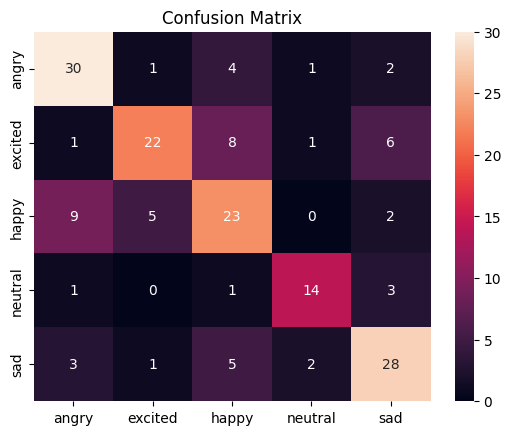

In [23]:
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(device)
        outputs = model(Xb)
        _, preds = torch.max(outputs, 1)
        y_true.extend(yb.numpy())
        y_pred.extend(preds.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=le.classes_))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.show()

## 10. Deployment Considerations
# Save best model

In [15]:

model_dir = "best_model"
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, "emotion_model.pth")
torch.save(model.state_dict(), model_path)
print(f"✅ Model saved at {model_path}")


✅ Model saved at best_model/emotion_model.pth


---
## Testing 


In [ ]:
# import sounddevice as sd
# from scipy.io.wavfile import write

# fs = 16000  # Sample rate
# duration = 3  # Seconds
# print("🎙️ Recording...")
# audio = sd.rec(int(duration * fs), samplerate=fs, channels=1)
# sd.wait()
# write("data/live_input.wav", fs, audio)
# print("✅ Saved to data/live_input.wav")


🎙️ Recording...
✅ Saved to data/live_input.wav


2. 🧪 Preprocess the Recorded Audio
Use the same feature extraction logic you used during training. For example:

In [17]:
import librosa
import numpy as np
import torch

def preprocess_live_audio(path, device, target_shape=(94, 92)):
    y, sr = librosa.load(path, sr=16000)
    y = librosa.util.fix_length(y, size=sr * 3)

    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=target_shape[0])

    # Pad or trim time axis to match target_shape[1]
    curr_frames = mfcc.shape[1]
    target_frames = target_shape[1]

    if curr_frames < target_frames:
        pad_width = target_frames - curr_frames
        mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
    elif curr_frames > target_frames:
        mfcc = mfcc[:, :target_frames]

    mfcc_tensor = torch.tensor(mfcc).unsqueeze(0).unsqueeze(0)  # shape: [1, 1, 94, 92]
    print(f"MFCC shape: {mfcc_tensor.shape}")
    return mfcc_tensor.to(device).float()






3. 🔍 Load Model and Predict


In [18]:
model = CNNEmotion(num_classes=5)  # or 4 if not including "excited"
model.load_state_dict(torch.load("best_model/emotion_model.pth"))
model.eval().to(device)

input_tensor = preprocess_live_audio("data/live_input.wav", device)
with torch.no_grad():
    output = model(input_tensor)
    pred_idx = torch.argmax(output, dim=1).item()

emotions = ['neutral', 'happy', 'sad', 'angry', 'excited']
print(f"🧠 Predicted Emotion: {emotions[pred_idx]}")



MFCC shape: torch.Size([1, 1, 94, 92])
🧠 Predicted Emotion: excited
